In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from datetime import datetime
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.coordinates import builtin_frames
from astropy.coordinates import Angle

In [3]:
x=[1,2,3,4,5,6]
x

[1, 2, 3, 4, 5, 6]

In [2]:
data = [0]*(199+201)
for i in range(0,199):
    with h5py.File('/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL2/20201118/dl2_LST-1.Run02929.{:04d}.h5'
               .format(i), 'r') as f:
        data[i] = pd.DataFrame(np.array(f['dl2/event/telescope/parameters/LST_LSTCam']))
        
for i in range(0,201):
    with h5py.File('/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL2/20201118/dl2_LST-1.Run02930.{:04d}.h5'
               .format(i), 'r') as f:
         data[199+i] = pd.DataFrame(np.array(f['dl2/event/telescope/parameters/LST_LSTCam']))
            
tot_data = pd.concat([data[i] for i in range(0,199+201)])
tot_data.head()

,intensity,log_intensity,x,y,r,phi,length,width,psi,skewness,...,log_reco_energy,reco_energy,reco_disp_dx,reco_disp_dy,reco_src_x,reco_src_y,reco_alt,reco_az,reco_type,gammaness
0,14019.949485,4.146746,-0.015204,-0.005036,0.016016,-2.821747,1.173447,1.142609,0.518989,0.023384,...,1.161159,14.493039,0.586236,0.238408,0.571033,0.233373,1.281348,1.902129,101,0.081857
1,76.737119,1.885005,-0.527041,-0.305895,0.609380,-2.615709,0.079877,0.073439,0.426368,0.060108,...,-1.459769,0.034692,-0.153171,-0.079658,-0.680212,-0.385553,1.236501,1.830964,101,0.386667
2,25.876774,1.412910,-0.349313,0.001244,0.349315,3.138032,0.088380,0.040477,0.769460,0.026443,...,-1.569809,0.026927,0.050654,0.022915,-0.298659,0.024159,1.250402,1.875670,101,0.305238
3,25.759664,1.410940,0.122801,-0.445033,0.461665,-1.301559,0.061317,0.053258,-1.157097,0.232783,...,-1.334617,0.046279,0.056081,-0.049218,0.178882,-0.494252,1.266962,1.813900,101,0.226262
4,44.028748,1.643736,-0.141567,0.933637,0.944309,1.721280,0.080193,0.045229,-1.103720,0.250541,...,-1.414461,0.038507,0.080160,0.050695,-0.061408,0.984333,1.256965,1.987032,101,0.251333


In [4]:
tot_data.columns

Index(['intensity', 'log_intensity', 'x', 'y', 'r', 'phi', 'length', 'width',
       'psi', 'skewness', 'kurtosis', 'time_gradient', 'intercept',
       'leakage_intensity_width_1', 'leakage_intensity_width_2',
       'leakage_pixels_width_1', 'leakage_pixels_width_2', 'n_pixels',
       'concentration_cog', 'concentration_core', 'concentration_pixel',
       'n_islands', 'alt_tel', 'az_tel', 'obs_id', 'event_id',
       'calibration_id', 'dragon_time', 'ucts_time', 'tib_time', 'mc_type',
       'mc_core_distance', 'wl', 'tel_id', 'tel_pos_x', 'tel_pos_y',
       'tel_pos_z', 'trigger_type', 'ucts_trigger_type', 'trigger_time',
       'log_reco_energy', 'reco_energy', 'reco_disp_dx', 'reco_disp_dy',
       'reco_src_x', 'reco_src_y', 'reco_alt', 'reco_az', 'reco_type',
       'gammaness'],
      dtype='object')

## Calculate the equatorial coordinates (right ascension and declination) of the events + make a skymap of the reconstructed directions of the events in these coordinates.

In [5]:
data = tot_data[(tot_data['gammaness']>0.8)]

In [6]:
def utc(df):   #function that calculates the utc time of the events  
    utc_time = []
    for i in range(df.shape[0]):
        idx = list(df.columns).index('dragon_time')
        a = datetime.utcfromtimestamp(df.iloc[i,idx])   #idx corresponds to the index of the column 'dragon_time'
        utc_time.append(a)
        
    return utc_time

In [7]:
def equatorial_coords(df):   #function that calculates the equatorial coordinates (ra and dec) of the events from the horizontal coordinates 
    utc_time = []
    for i in range(df.shape[0]):
        idx = list(df.columns).index('dragon_time')
        a = datetime.utcfromtimestamp(df.iloc[i,idx])   #idx corresponds to the index of the column 'dragon_time'
        utc_time.append(a)

    df = df.assign(utc_time = utc_time)   #add new column to the data frame with the UTC observation times of the events

    loc = EarthLocation(lat = 28.76152611*u.deg, lon = -17.89149701*u.deg, height = 2184*u.m)   #location of the telescope (CTA LST1: Roque de los Muchachos)

    hor_coords = SkyCoord(alt = df['reco_alt'], az = df['reco_az'], frame = 'altaz', unit = 'rad', 
                          obstime = df['utc_time'], location = loc)   #horizontal coordinates of the events
    eq_coords = hor_coords.icrs   #equatorial coordinates of the events
    
    return eq_coords

In [38]:
utc_time = utc(data)
eq_coords = equatorial_coords(data)

data = data.assign(utc_time = utc_time)   #add new column to the data frame with the UTC observation times of the events
data = data.assign(RA = eq_coords.ra)   #add columns with right ascension and declination (equatorial coordinates) of the events
data = data.assign(DEC = eq_coords.dec)

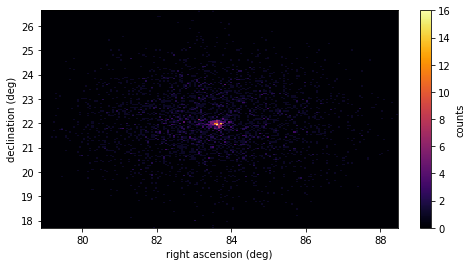

In [8]:
# skymap (RA, dec) de las posiciones reconstruidas de los sucesos (ya se ha aplicado el corte de gammaness > 0.8):
plt.figure(figsize=(8,4))
h = plt.hist2d(data['RA'], data['DEC'], bins = 175, cmap = 'inferno')
plt.xlabel('right ascension (deg)')
plt.ylabel('declination (deg)')
plt.colorbar(label='counts')

## Ver que hay un exceso significativo de sucesos (gammas) en las coordenadas del Crab y estimar el número de gammas (haciendo "aperture photometry"), tomando 3 zonas off creando una cruz con la posición del Crab (para tener más estadística para calcular el fondo).

In [9]:
data1 = data[(data['intensity']>200)]

In [91]:
def gamma_excess(df):    #function that returns the excess of gamma rays of a given dataframe (with a given cut in gammaness)
    crab = SkyCoord.from_name('M1')    #equatorial coordinates of the Crab nebula in deg

    eq_coords = SkyCoord(df['RA'], df['DEC'], frame='icrs', unit='deg')   #frame 'icrs' = equatorial coordinates (of the events)
    df = df.assign(theta2 = (eq_coords.separation(crab))**2)  #square of the angular separation between the events and the crab (in deg)
    
    loc = EarthLocation(lat = 28.76152611*u.deg, lon = -17.89149701*u.deg, height = 2184*u.m)
    hor_coords_tel = SkyCoord(alt = df['alt_tel'], az = df['az_tel'], frame = 'altaz', unit = 'rad', 
                          obstime = df['utc_time'], location = loc)   #horizontal coordinates of the telescope
    eq_coords_tel = hor_coords_tel.icrs   #equatorial coordinates of the telescope

    skyoffset_frame = builtin_frames.SkyOffsetFrame(origin = eq_coords_tel)  #define a new reference frame centered at the pointing direction of the telescope at each moment

    crab2 = crab.transform_to(skyoffset_frame)   #position of the Crab nebula with respect to the new frame 

    pos = [0]*3
    theta2_off = [0]*3
    pos[0] = SkyCoord(-crab2.lon, -crab2.lat, frame = skyoffset_frame, unit = 'deg')  #symmetric position to the position of the Crab with respect to the center of the FOV
    pos[1] = SkyCoord(Angle(crab2.lat), Angle(-crab2.lon), frame = skyoffset_frame, unit = 'deg') 
    pos[2] = SkyCoord(Angle(-crab2.lat), Angle(crab2.lon), frame = skyoffset_frame, unit = 'deg') 

    for i in range(3):
        pos[i] = pos[i].transform_to('icrs') 
        theta2_off[i] = (eq_coords.separation(pos[i]))**2  #square of the angilar separation between the events and each of the off zones

    df = df.assign(theta2_off1 = theta2_off[0])
    df = df.assign(theta2_off2 = theta2_off[1])
    df = df.assign(theta2_off3 = theta2_off[2])
    par = ['theta2', 'theta2_off1', 'theta2_off2', 'theta2_off3']

    n = [0]*4
    b = [0]*4
    p = [0]*4
    plt.figure(figsize=(10,6))
    for i in range(4):
        (n[i],b[i],p[i]) = plt.hist(df[par[i]], bins=750, histtype = 'step')
        plt.errorbar((b[i][1:]+b[i][:-1])/2, n[i], fmt = 'none', ecolor='gray', yerr=np.sqrt(n2), elinewidth=0.5, capsize=1)

    plt.xlabel(r'$\theta²$')
    plt.ylabel('counts')
    plt.xlim(0, 2.5)

    excess_gammas = n[0][0]+n[0][1]-np.mean([n[1][0],n[2][0],n[3][0]])-np.mean([n[1][1],n[2][1],n[3][1]])
    return print('Excess of gamma rays: {}'. format(excess_gammas))

Excess of gamma rays: 209.66666666666666


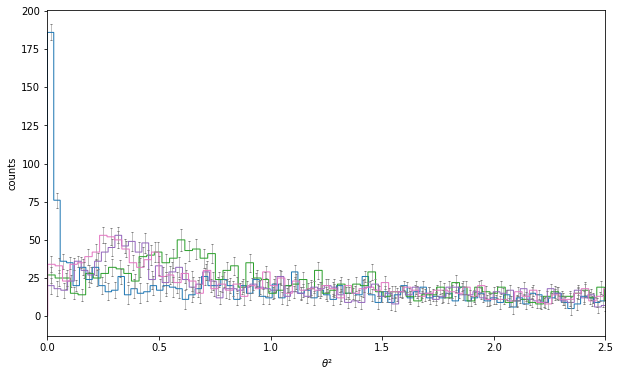

In [92]:
gamma_excess(data1)

## Obtain the distribution of theta², width, length and intensity of (only) the gamma rays.

#### *** ERROR PROPAGATION: 

($n_1$, $n_2$, $n_3$, $n_4$): histogram bins (for each position) 

($\sqrt{n_1}$, $\sqrt{n_2}$, $\sqrt{n_3}$, $\sqrt{n_4}$): errors of each "variable" ($n_i$)

new variable (function of $(n_1, n_2, n_3, n_4)$): $n(n_1, n_2, n_3, n_4)=n_1-\frac{1}{3}(n_2+n_3+n_4)$

Covariance matrix of the variables $n_i$ (since $\sigma_i=\sqrt{n_i}$ and $cov(x_i,x_i)=\sigma_i²$): 

\begin{equation*}
V = cov[n_i,n_j]=
\begin{pmatrix}
n_1 &  &  & \\
& n_2 &  & \\
 &  & n_3 &  \\
 &  &  &  n_4
\end{pmatrix}
\end{equation*}

To obtain the variance $U$ of the variable $n$, we use error propagation: 
$$U = \sum_{k,l=1}^n \frac{\partial n}{\partial n_i} \frac{\partial n}{\partial n_j} V_{kl}$$
$$A_1 = \frac{\partial n}{\partial n_1}=1  ; \quad A_2=A_3=A_4=-1/3 \quad \Rightarrow U=V_{11}+\frac{1}{9}(V_{22}+V_{33}+V_{44})$$

In [140]:
def distribution(df, parameter):   #function that returns the distribution of a given parameter using a given dataframe (with a given cut in gammaness)
    crab = SkyCoord.from_name('M1')    #equatorial coordinates of the Crab nebula in deg

    eq_coords = SkyCoord(df['RA'], df['DEC'], frame='icrs', unit='deg')   #frame 'icrs' = equatorial coordinates (of the events)
    df = df.assign(theta2 = (eq_coords.separation(crab))**2)  #square of the angular separation between the events and the crab (in deg)

    loc = EarthLocation(lat = 28.76152611*u.deg, lon = -17.89149701*u.deg, height = 2184*u.m)
    hor_coords_tel = SkyCoord(alt = df['alt_tel'], az = df['az_tel'], frame = 'altaz', unit = 'rad', 
                          obstime = df['utc_time'], location = loc)   #horizontal coordinates of the telescope
    eq_coords_tel = hor_coords_tel.icrs   #equatorial coordinates of the telescope

    skyoffset_frame = builtin_frames.SkyOffsetFrame(origin = eq_coords_tel)  #define a new reference frame centered at the pointing direction of the telescope at each moment

    crab2 = crab.transform_to(skyoffset_frame)   #position of the Crab nebula with respect to the new frame 

    pos = [0]*3
    theta2_off = [0]*3
    pos[0] = SkyCoord(-crab2.lon, -crab2.lat, frame = skyoffset_frame, unit = 'deg')  #symmetric position to the position of the Crab with respect to the center of the FOV
    pos[1] = SkyCoord(Angle(crab2.lat), Angle(-crab2.lon), frame = skyoffset_frame, unit = 'deg') 
    pos[2] = SkyCoord(Angle(-crab2.lat), Angle(crab2.lon), frame = skyoffset_frame, unit = 'deg') 

    for i in range(3):
        pos[i] = pos[i].transform_to('icrs') 
        theta2_off[i] = (eq_coords.separation(pos[i]))**2   #square of the angilar separation between the events and each of the off zones

    df = df.assign(theta2_off1 = theta2_off[0])
    df = df.assign(theta2_off2 = theta2_off[1])
    df = df.assign(theta2_off3 = theta2_off[2])
    
    idx = list(df.columns).index(parameter)
    par = df.columns[idx] 
    
    gammas = df[(df['theta2']<0.05)]   #dataframe that contains only the events 0.05 degrees around the position of the crab (gammas + bkg of cosmic rays)
    bkg2 = df[(df['theta2_off1']<0.05)]   #dataframe that contains only the events 0.05 degrees around the off zone 1 (bkg of cosmic rays)
    bkg3 = df[(df['theta2_off2']<0.05)]   #dataframe that contains only the events 0.05 degrees around the off zone 2 (bkg of cosmic rays)
    bkg4 = df[(df['theta2_off3']<0.05)]   #dataframe that contains only the events 0.05 degrees around the off zone 3 (bkg of cosmic rays)
    
    df1 = [gammas, bkg2, bkg3, bkg4]
    n = []
    b = []
    plt.figure(figsize=(20,6))
    plt.subplot(121)
    for i in range(4):
        name = df1[i]
        (n1,b1,p1)= plt.hist(name[par], histtype = 'step', bins = 100, range = (min(df[par]),max(df[par])))
        n.append(n1)
        b.append(b1)
        plt.errorbar((b[i][1:]+b[i][:-1])/2, n[i], fmt = 'none', ecolor='gray', yerr=np.sqrt(n[i]), elinewidth=0.5, capsize=1)
       
    plt.xlabel(parameter)
    plt.ylabel('counts')
    plt.title('Distribution of {} of the events + background of cosmic rays'.format(par))

    N = n[0]-(1/3)*(n[1]+n[2]+n[3])  #histogram bins of only the gamma rays (without the bkg of cosmic rays)
    err_N = np.sqrt(n[0]+1/9*(n[1]+n[2]+n[3]))  #error of N, obtained by error propagation 

    width = b[1][1] - b[1][0]
    plt.subplot(122)
    plt.bar(b[1][:-1], N, align='edge', width=width)
    plt.errorbar((b[1][1:]+b[1][:-1])/2, N, fmt = 'none', ecolor='k', yerr=err_N, elinewidth=0.5, capsize=1)
    plt.xlabel(parameter)
    plt.ylabel('counts')
    plt.title('Distribution of {} of the gamma rays (the background of cosmic rays has been substracted)'.format(par))

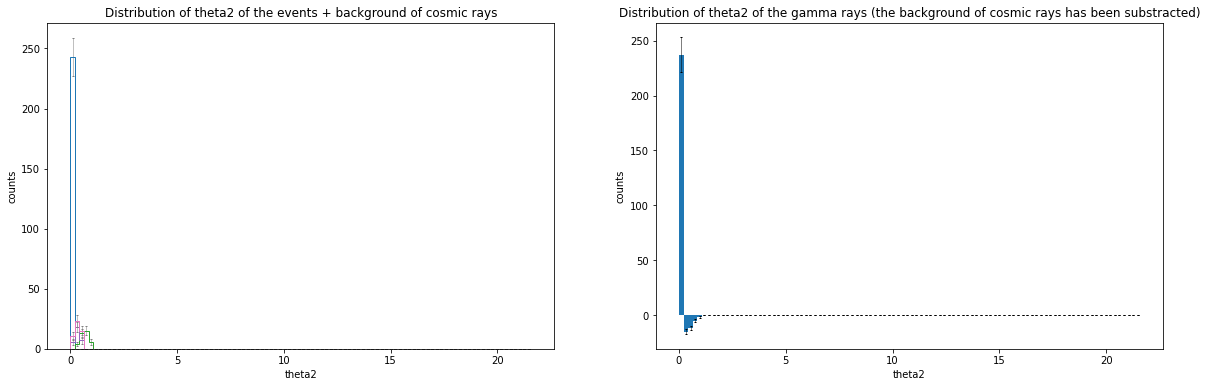

In [141]:
distribution(data1, 'theta2')

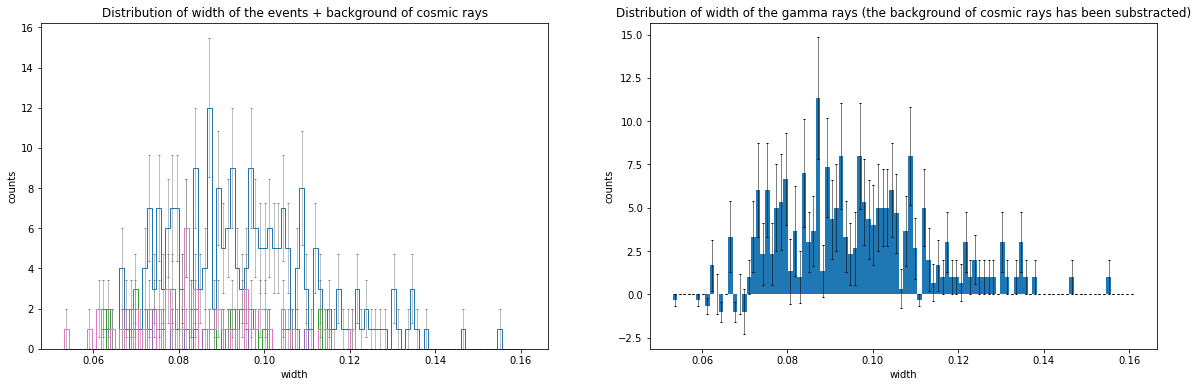

In [142]:
distribution(data1, 'width')

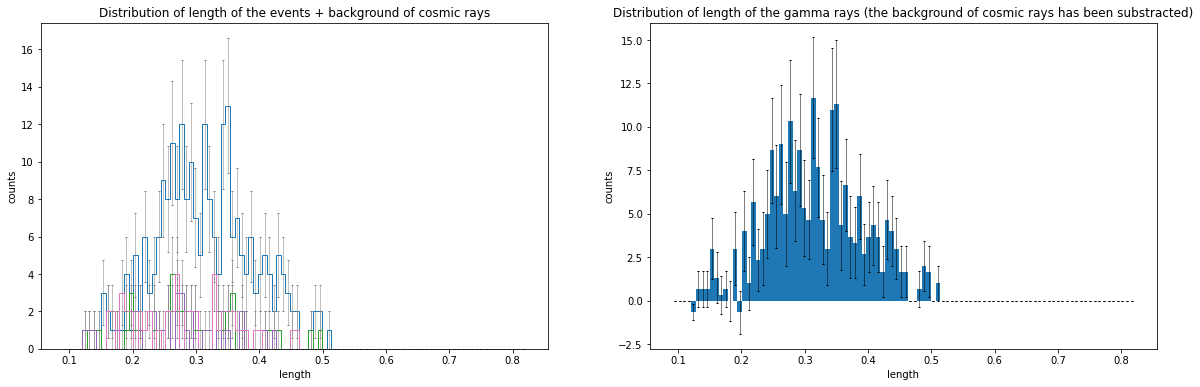

In [143]:
distribution(data1, 'length')

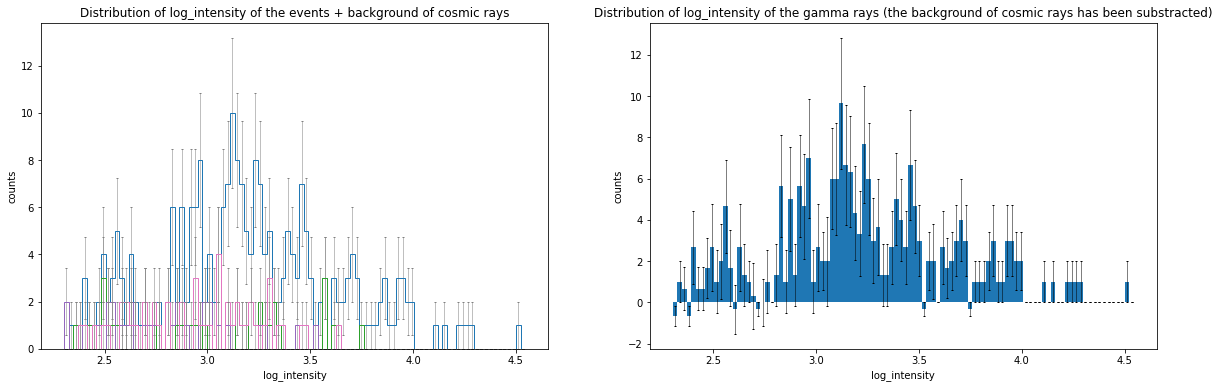

In [144]:
distribution(data1, 'log_intensity')

In [150]:
def hist_intensity(df, parameter):  #function that returns the plot of a given parameter in bins of intensity
    crab = SkyCoord.from_name('M1')    #equatorial coordinates of the Crab nebula in deg

    eq_coords = SkyCoord(df['RA'], df['DEC'], frame='icrs', unit='deg')   #frame 'icrs' = equatorial coordinates (of the events)
    df = df.assign(theta2 = (eq_coords.separation(crab))**2)  #square of the angular separation between the events and the crab (in deg)

    loc = EarthLocation(lat = 28.76152611*u.deg, lon = -17.89149701*u.deg, height = 2184*u.m)
    hor_coords_tel = SkyCoord(alt = df['alt_tel'], az = df['az_tel'], frame = 'altaz', unit = 'rad', 
                          obstime = df['utc_time'], location = loc)   #horizontal coordinates of the telescope
    eq_coords_tel = hor_coords_tel.icrs   #equatorial coordinates of the telescope 

    skyoffset_frame = builtin_frames.SkyOffsetFrame(origin = eq_coords_tel)  #define a new reference frame centered at the pointing direction of the telescope at each moment

    crab2 = crab.transform_to(skyoffset_frame)   #position of the Crab nebula with respect to the new frame 

    pos = [0]*3
    theta2_off = [0]*3
    pos[0] = SkyCoord(-crab2.lon, -crab2.lat, frame = skyoffset_frame, unit = 'deg')  #symmetric position to the position of the Crab with respect to the center of the FOV
    pos[1] = SkyCoord(Angle(crab2.lat), Angle(-crab2.lon), frame = skyoffset_frame, unit = 'deg') 
    pos[2] = SkyCoord(Angle(-crab2.lat), Angle(crab2.lon), frame = skyoffset_frame, unit = 'deg') 

    for i in range(3):
        pos[i] = pos[i].transform_to('icrs') 
        theta2_off[i] = (eq_coords.separation(pos[i]))**2   #square of the angilar separation between the events and each of the off zones

    df = df.assign(theta2_off1 = theta2_off[0])
    df = df.assign(theta2_off2 = theta2_off[1])
    df = df.assign(theta2_off3 = theta2_off[2])
    
    idx = list(df.columns).index(parameter)
    par = df.columns[idx] 
    
    gammas = df[(df['theta2']<0.05)]   #dataframe that contains only the events 0.05 degrees around the position of the crab (gammas + bkg of cosmic rays)
    bkg2 = df[(df['theta2_off1']<0.05)]   #dataframe that contains only the events 0.05 degrees around the off zone 1 (bkg of cosmic rays)
    bkg3 = df[(df['theta2_off2']<0.05)]   #dataframe that contains only the events 0.05 degrees around the off zone 2 (bkg of cosmic rays)
    bkg4 = df[(df['theta2_off3']<0.05)]   #dataframe that contains only the events 0.05 degrees around the off zone 3 (bkg of cosmic rays)

    df1 = [gammas, bkg2, bkg3, bkg4]
    b = []
    for i in range(4):
        name = df1[i]
        b.append(np.histogram(name[par], bins = 100, range = (min(df[par]),max(df[par])))[1]) 

    df1 = gammas[(gammas[par]>=b[1][0]) & (gammas[par]<=b[1][1])]
    df2 = bkg2[(bkg2[par]>=b[1][0]) & (bkg2[par]<=b[1][1])]
    df3 = bkg3[(bkg3[par]>=b[1][0]) & (bkg3[par]<=b[1][1])]
    df4 = bkg4[(bkg4[par]>=b[1][0]) & (bkg4[par]<=b[1][1])]
    n = [df1.sum(axis=0)['intensity']-(1/3)*(df2.sum(axis=0)['intensity']+df3.sum(axis=0)['intensity']+
                                              df4.sum(axis=0)['intensity'])]    #intensity
    for i in range(1,len(b[1])-1):
        df1 = gammas[(gammas[par]>b[1][i]) & (gammas[par]<=b[1][i+1])]
        df2 = bkg2[(bkg2[par]>b[1][i]) & (bkg2[par]<=b[1][i+1])]
        df3 = bkg3[(bkg3[par]>b[1][i]) & (bkg3[par]<=b[1][i+1])]
        df4 = bkg4[(bkg4[par]>b[1][i]) & (bkg4[par]<=b[1][i+1])]
        n1 = df1.sum(axis=0)['intensity']-(1/3)*(df2.sum(axis=0)['intensity']+df3.sum(axis=0)['intensity']+
                                              df4.sum(axis=0)['intensity'])   #intensity
        n.append(n1)

    plt.figure(figsize=(8,5))
    plt.bar(b[1][:-1], n, align='edge', width=b[1][0]-b[1][1])
    plt.xlabel(parameter)
    plt.ylabel('intensity')
    plt.title('Intensity of the gamma ray events as a function of the {}'.format(parameter))

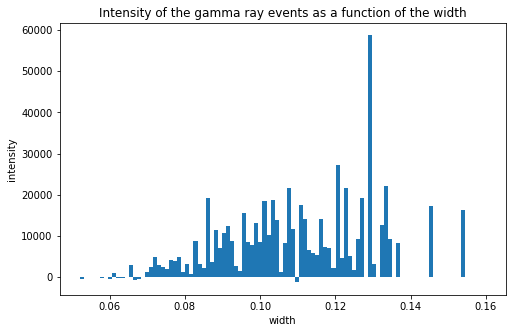

In [151]:
hist_intensity(data1, 'width')

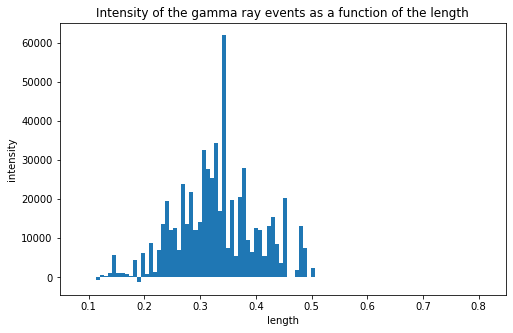

In [152]:
hist_intensity(data1, 'length')

## Do the same (obtain the distributions of some parameters) but with a less hard cut in gammaness: gammaness > 0.5

In [153]:
data2 = tot_data[(tot_data['gammaness']>0.5) & (tot_data['intensity']>200)]

In [154]:
utc_time = utc(data2)
eq_coords = equatorial_coords(data2)

data2 = data2.assign(utc_time = utc_time)   #add new column to the data frame with the UTC observation times of the events
data2 = data2.assign(RA = eq_coords.ra)   #add columns with right ascension and declination (equatorial coordinates) of the events
data2 = data2.assign(DEC = eq_coords.dec)

Excess of gamma rays: 1005.3333333333335


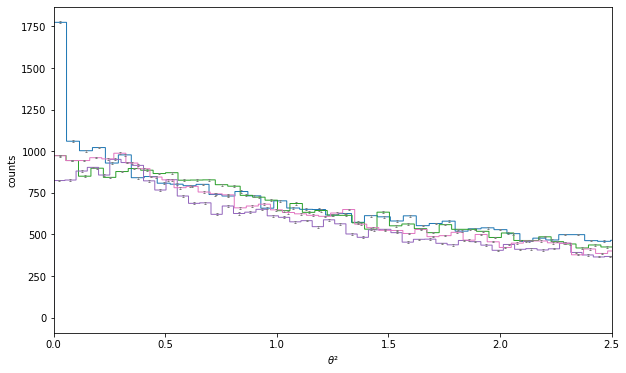

In [155]:
gamma_excess(data2)

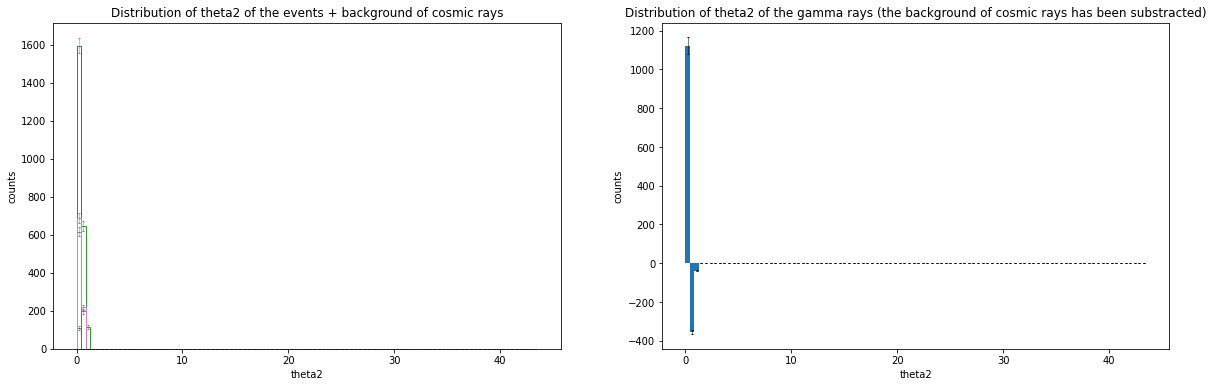

In [156]:
distribution(data2, 'theta2')

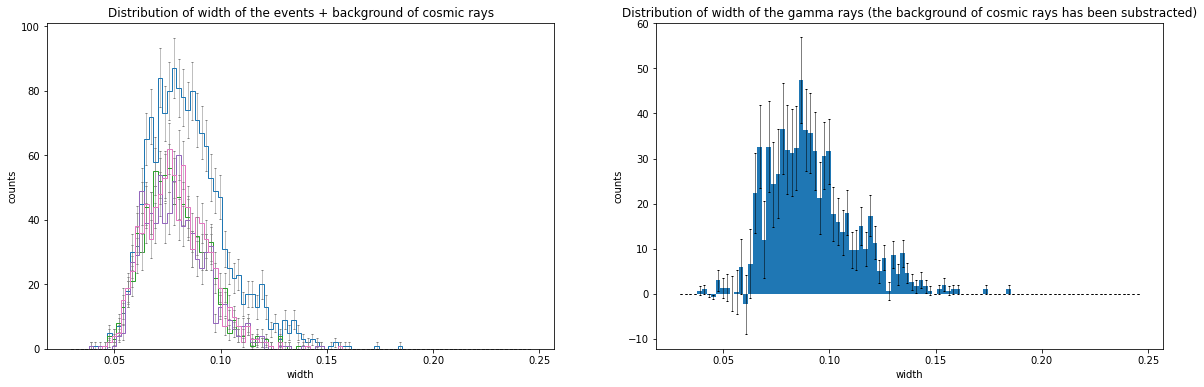

In [157]:
distribution(data2, 'width')

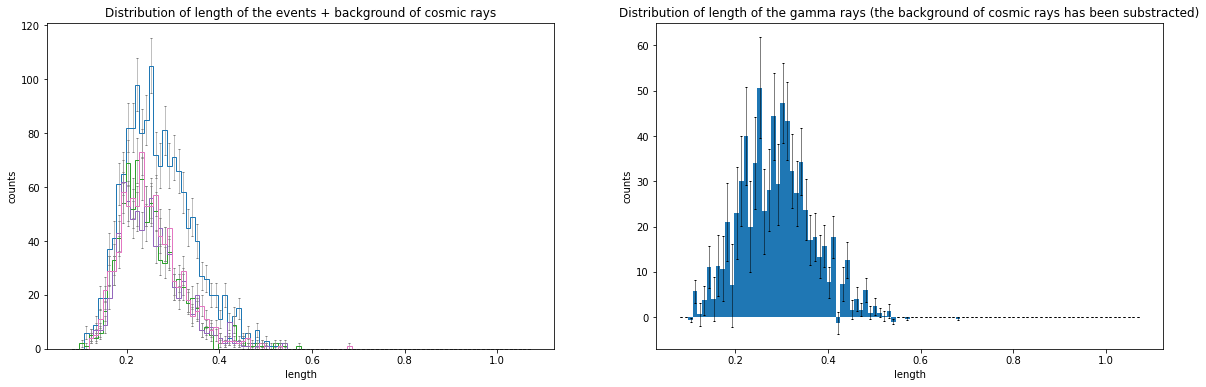

In [158]:
distribution(data2, 'length')

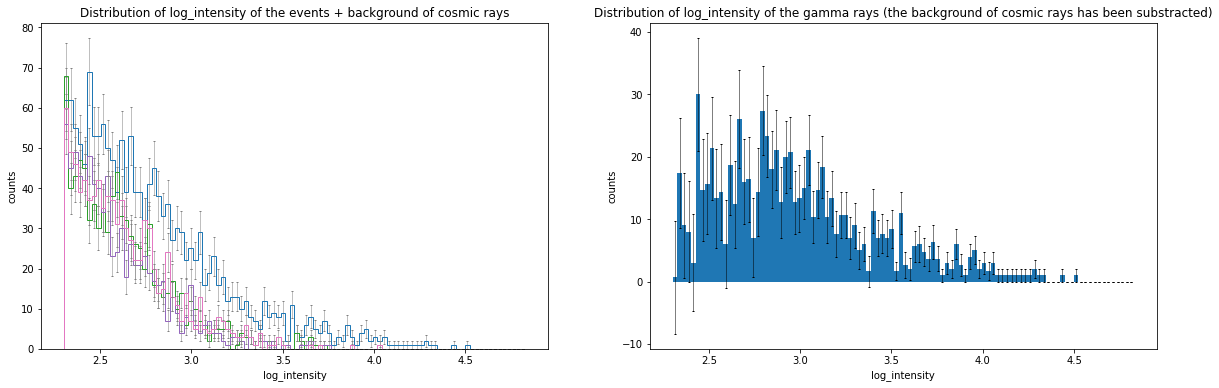

In [159]:
distribution(data2, 'log_intensity')

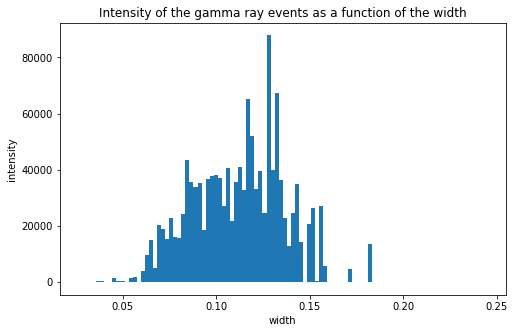

In [160]:
hist_intensity(data2, 'width')

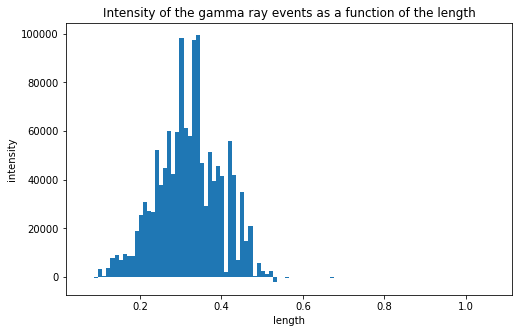

In [161]:
hist_intensity(data2, 'length')